In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# We get a lot of warnings about slices of copies, these are not meaningful.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define our source files
COVID_file = 'COVID_by_County/COVID_by_County.csv'
pop_file = 'popData.csv'
US_county_land_file = 'LND01.csv'
US_county_vote_file = 'president_county_candidate.csv'
mask_use_file = '../covid-19-data/mask-use/mask-use-by-county.csv'

# Read the source files into dataframes.
COVID_data = pd.read_csv(COVID_file)
pop_data = pd.read_csv(pop_file)
land_data = pd.read_csv(US_county_land_file)
vote_data = pd.read_csv(US_county_vote_file)
mask_use = pd.read_csv(mask_use_file)

In [3]:
# Rename some of the columns
COVID_data = COVID_data.rename(columns={'countyFIPS':'fips'})
pop_data = pop_data.rename(columns={'FIPS':'fips', 'Poverty Percent':'Poverty_pct'})
land_data = land_data.rename(columns={'STCOU':'fips','LND010190D':'land'})

# We don't need most of this dataframe so we truncate it down.
land_data = land_data[['fips','land']]

# the vote data is stores as a mixture of row and column data so we jump through hoops to make it usable.
Biden = vote_data[vote_data.candidate == 'Joe Biden']
trump = vote_data[vote_data.candidate == 'Donald Trump']
vote_data = Biden[['state', 'county', 'total_votes']].copy()
vote_data.rename(columns={'total_votes':'Biden'}, inplace=True)
vote_data['Trump'] = trump.total_votes.to_numpy()

# We need some definition that allows us to compare to similar categories.
mask_use['mask_pct'] = mask_use['FREQUENTLY'] + mask_use['ALWAYS']

# merge the vote data into the populationm data, we can't do this on the main dataframe DF because vote data does not use fips.
pop_data = pd.merge(pop_data, vote_data, left_on = ['CTYNAME', 'STNAME'], right_on = ['county','state'])

In [4]:
# Merge all the datasets into one main dataframe, DF.  Fioltering down when necessary.
DF = pd.merge(COVID_data, pop_data[['fips', 'POPESTIMATE2018', 'Poverty_pct', 'Biden', 'Trump']], left_on='fips', right_on='fips')
DF = pd.merge(DF,land_data,  left_on='fips', right_on='fips')
DF = pd.merge(DF, mask_use[['COUNTYFP','mask_pct']], left_on = 'fips', right_on = 'COUNTYFP')

# We need to make sure the poverty data is converted from an object type.
DF.Poverty_pct = DF.Poverty_pct.astype('float')

# We don't need NaN entries, they will only cause issues.
DF = DF.dropna()

# write out the dataframe to check.
DF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct
0,1/22/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
1,1/23/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
2,1/24/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
3,1/25/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
4,1/26/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,6924,11.8,360,3107,2400.13,56045,0.581
982885,12/6/2020,56045,Weston County,WY,420,2,6924,11.8,360,3107,2400.13,56045,0.581
982886,12/7/2020,56045,Weston County,WY,422,2,6924,11.8,360,3107,2400.13,56045,0.581
982887,12/8/2020,56045,Weston County,WY,425,2,6924,11.8,360,3107,2400.13,56045,0.581


In [5]:
# Need to fix some counties that have 0 area in the dataset, data manually found with Google.
DF.land[DF['County Name'] == 'Broomfield County and City'] = 33.55
DF.land[DF['County Name'] == 'Yakutat City and Borough'] = 9463
DF.land[DF['County Name'] == 'Denali Borough'] = 12777
DF.land[DF['County Name'] == 'Skagway Municipality'] = 464
DF.land[DF['County Name'] == 'Wrangell City and Borough'] = 3477

# We create new columns containing per capita data
DF['cases_per_100k'] = DF.cases / DF.POPESTIMATE2018 * 100000
DF['deaths_per_100k'] = DF.deaths / DF.POPESTIMATE2018 * 100000
DF['pop_density'] = DF.POPESTIMATE2018 / DF.land
DF['Biden_per_100k'] = DF.Biden /DF.POPESTIMATE2018 * 100000
DF['Trump_per_100k'] = DF.Trump /DF.POPESTIMATE2018 * 100000
DF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_100k,deaths_per_100k,pop_density,Biden_per_100k,Trump_per_100k
0,1/22/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
1,1/23/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
2,1/24/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
3,1/25/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
4,1/26/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,6924,11.8,360,3107,2400.13,56045,0.581,6051.415367,28.885038,2.884844,5199.306759,44872.905835
982885,12/6/2020,56045,Weston County,WY,420,2,6924,11.8,360,3107,2400.13,56045,0.581,6065.857886,28.885038,2.884844,5199.306759,44872.905835
982886,12/7/2020,56045,Weston County,WY,422,2,6924,11.8,360,3107,2400.13,56045,0.581,6094.742923,28.885038,2.884844,5199.306759,44872.905835
982887,12/8/2020,56045,Weston County,WY,425,2,6924,11.8,360,3107,2400.13,56045,0.581,6138.070479,28.885038,2.884844,5199.306759,44872.905835


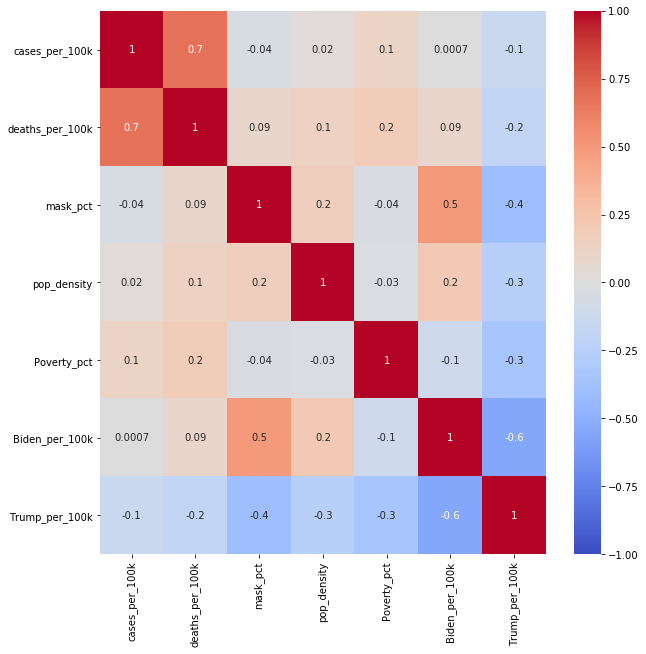

In [6]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(DF[['cases_per_100k','deaths_per_100k','mask_pct','pop_density','Poverty_pct','Biden_per_100k','Trump_per_100k']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [8]:
# Create some very macabre fits.
deaths_fit = sm.OLS(DF['deaths_per_100k'],sm.add_constant(DF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        deaths_per_100k   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                 1.435e+04
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:54:31   Log-Likelihood:            -5.1283e+06
No. Observations:              982889   AIC:                         1.026e+07
Df Residuals:                  982883   BIC:                         1.026e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6592      0.492     -1.

In [9]:
cases_fit = sm.OLS(DF['cases_per_100k'],sm.add_constant(DF[['Poverty_pct','pop_density']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8053.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:54:31   Log-Likelihood:            -8.7249e+06
No. Observations:              982889   AIC:                         1.745e+07
Df Residuals:                  982886   BIC:                         1.745e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         575.8038      4.741    121.440      